In [5]:
%load_ext rmagic

/usr/local/lib/python2.7/dist-packages/IPython/extensions/rmagic.py:693: UserWarning: The rmagic extension in IPython is deprecated in favour of rpy2.ipython. If available, that will be loaded instead.
http://rpy.sourceforge.net/
  warnings.warn("The rmagic extension in IPython is deprecated in favour of "


# [導讀] 股票市場的預測
* <a href='http://www.pcstore.com.tw/pchome24h/M19720645.htm'>基礎R語言與商業應用：第八章</a>
* C.Y. Yen
* July @ TW RLadies

### Outline
* 問題：使用歷史資料來預測單一股票的未來績效表現
* 處理流程
    1. 取得股價時間序列：以 quantmod 取得資料，以 xts 套件整理資料
    2. 設定預測目標             
    3. 預測變數是什麼：以 Random Forest 選擇重要的變數 (降維)
    4. 建模型：以 Support Vector Machine 做分類
    5. 評估模型表現

### 在這個章節中，你需要了解的 Machine Learning Algorithm
* Random Forest 隨機森林
* Support Vector Machine 支援向量機

#### Decision Tree & Random Forest
* 用來分類
* 用來衡量變數的重要性
<img src='fig/decision_tree.jpg'>

<img src='fig/random_forest.jpg'>

<img src='fig/random_forest_ensemble.png' height=430>

#### Support Vector Machine
<img src='fig/svm_spirit.png'>

 #### 1. 取得股價時間序列：以 xts 套件整理

In [11]:
%%R
library(quantmod)
. <- getSymbols(Symbols = "^SSEC",src = "yahoo")
head(SSEC)

           SSEC.Open SSEC.High SSEC.Low SSEC.Close SSEC.Volume SSEC.Adjusted
2007-01-04  2728.188  2847.615 2684.818   2715.719      120200      2715.719
2007-01-05  2668.577  2685.804 2617.019   2641.334      106200      2641.334
2007-01-08  2621.068  2708.444 2620.625   2707.199      106800      2707.199
2007-01-09  2711.049  2809.394 2691.360   2807.804      110800      2807.804
2007-01-10  2838.113  2841.741 2770.988   2825.576      111800      2825.576
2007-01-11  2819.367  2841.180 2763.886   2770.110      121600      2770.110


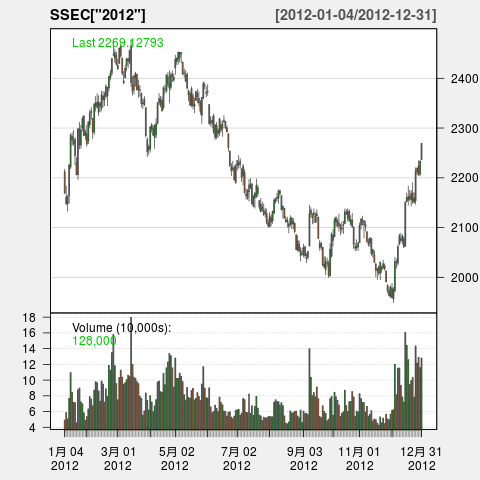

In [12]:
%%R
candleChart(x=SSEC["2012"], theme="white")

In [3]:
%%R
#----------------------------------------
# Package xts
#----------------------------------------
library(xts)
(x <- xts(x=data.frame(x=1:13,y=13:1), 
order.by=seq(from=as.POSIXct("2012-05-23"),length.out=13,by="day")))
class(x)
x[1:2,]
x["2012-05-23"]
x["2012-05-29/"]
x["2012-05-21/2012-05-23"]
x["2012-05-23"]
x["2012-06"]
time(x)
coredata(x)

       x  y
 [1,]  1 13
 [2,]  2 12
 [3,]  3 11
 [4,]  4 10
 [5,]  5  9
 [6,]  6  8
 [7,]  7  7
 [8,]  8  6
 [9,]  9  5
[10,] 10  4
[11,] 11  3
[12,] 12  2
[13,] 13  1


#### 2. 目標是什麼：定義交易邏輯               
   

In [4]:
%%R
#------------------------------------------------
# Get the measurement index - Profit > Cost
#T.Index <- function(data,p,k)
# ------------------------------------------------
p <- 0.025
k <- 10
hlc <- HLC(SSEC["2012"])
P <- rowMeans(hlc)
V <- matrix(NA,ncol=k, nrow=NROW(P))
for (i in 1:k)
{
  V[,i] <- Next(Delt(P,k=i),k=i)
}
T <- apply(V,1,function(x) sum(x[abs(x) > p]))
T <- xts(x=T, order.by=time(SSEC["2012"]))


#----------------------------------------
# Optimize - To perform as a function
# T.Index <- function(data,p,k)
#----------------------------------------

T.Index <- function(data,p,k)
{
  hlc <- HLC(data)
  #hlc <- HLC(SSEC["2012"])
  P <- rowMeans(hlc)
  V <- matrix(NA,ncol=k,nrow=NROW(P))
  for (i in 1:k) 
  {
    V[,i] <- Next(Delt(P,k=i), k=i)
  }
  T <- apply(V,1,function(x) sum(x[abs(x) > p]))
  T <- xts(x=T, order.by=time(data))
  return(T)
}
#T <- T.Index(data=SSEC["2012"],p=0.025,k=10)
T <- T.Index(data=SSEC["2012"],p=0.025,k=10)

#### 3. 預測變數是什麼：以 Random Forest 選擇重要的變數 (降維)

Loading required package: randomForest
randomForest 4.6-10
Type rfNews() to see new features/changes/bug fixes.


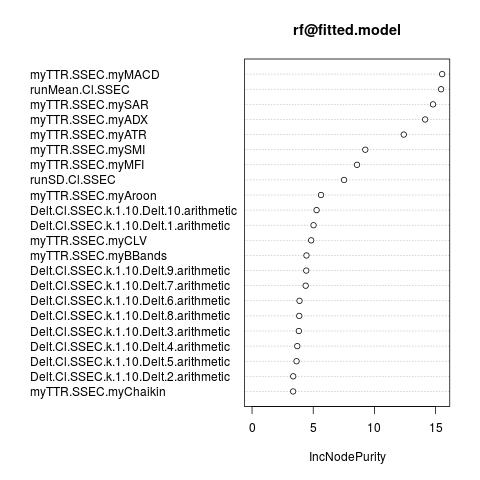

In [6]:
%%R
#----------------------------------------
# Prediction Approach
#----------------------------------------
require(TTR)
require(quantmod)
myTTR <- function(data)
{
  names(data) <- sapply(X=names(SSEC),FUN=function(x) strsplit(x,split=".",fixed=TRUE) [[1]] [2])
  myATR <- ATR(HLC(data))$atr
  mySMI <- SMI(HLC(data))$SMI
  myADX <- ADX(HLC(data))$ADX
  myAroon <- aroon(HLC(data)[,-3])$oscillator
  myBBands <- BBands(HLC(data))$pctB
  myChaikin <- Delt(chaikinVolatility(HLC(data)[,-3]))[,1]
  myCLV <- EMA(CLV(HLC(data)))[,1]
  myMACD <- MACD(data[,"Close"])[,2]
  myMFI <- MFI(data[,c("High","Low","Close")],data[,"Volume"])
  mySAR <- SAR(data[,c("High","Close")])[,1]
  result <- cbind(myATR,mySMI,myADX,myAroon,myBBands,myChaikin,myCLV,myMACD,myMFI,mySAR)
  colnames(result) <- c("myATR","mySMI","myADX","myAroon","myBBands","myChaikin","myCLV","myMACD","myMFI","mySAR")
  return(result)
}

#----------------------------------------
#Forrest Random
#----------------------------------------
#require(quantmod)

# decision tree:  http://www.slideshare.net/DebdootSheet/decision-trees-and-random-forests
require(randomForest)

model <- specifyModel(formula=T.Index(SSEC,p=0.025,k=10) ~ Delt(Cl(SSEC),k=1:10)+
                      myTTR(SSEC)+runMean(Cl(SSEC))+runSD(Cl(SSEC)),
                      na.rm=TRUE)

set.seed(42)
#---------------------------------------
# below builModel took a bit minutes
#---------------------------------------
rf <- buildModel(x=model,method="randomForest",training.per=c(start(SSEC),index(SSEC["2011-10-12"])))
varImpPlot(rf@fitted.model)
x <- importance(rf@fitted.model)
#@: S4: http://adv-r.had.co.nz/S4.html
rownames(x) [x >12]

#----------------------------------------
# Model's Prediction
#----------------------------------------
myTTR.data <- myTTR(SSEC)[,c("myATR","mySMI","myADX","myMACD","mySAR")]
model.data <- specifyModel(formula=T.Index(SSEC,p=0.025,k=10) ~ myTTR.data+runMean(Cl(SSEC)))
train.data <- as.data.frame(modelData(model.data,data.window=c(start(SSEC),"2012-12-31")))
test.data <- as.data.frame(modelData(model.data, data.window=c(as.Date("2013-01-05"), end(SSEC))))
colnames(train.data) <- c("T","myATR","mySMI","myADX","myMACD","mySAR","runMean")
colnames (test.data) <- c("T","myATR","mySMI","myADX","myMACD","mySAR","runMean")
form <- as.formula("T~.")

####   4. 建模型：以 Support Vector Machine 做分類

In [7]:
%%R
library(e1071)
# svm 
# https://cg2010studio.wordpress.com/2012/05/20/%E6%94%AF%E6%8C%81%E5%90%91%E9%87%8F%E6%A9%9F%E5%99%A8-support-vector-machine/
m <- svm(form, train.data,cost=100)
p <- predict(m,na.omit(test.data))

#### 5. 評估模型表現

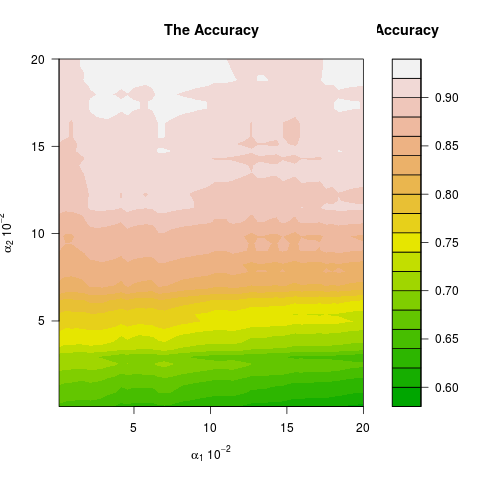

In [8]:
%%R
#----------------------------------------
# To Use The Evaluation Prediciton Value
#----------------------------------------
T2Signal <- function(x,a1 = -0.01, a2 = -a1)
{
  result <- ifelse(x < a1, "Sell", ifelse(x > a2, "Buy", "Hold"))
  result <- factor(result)
  return(result)
}

signal.p <- T2Signal(x=p, a1 = -0.095, a2 = 0.095)
signal.true <- T2Signal(x=na.omit(test.data)$T, a1 = -0.095, a2 = 0.095)
table(signal.p, signal.true)

accuracy <- function(prediction, true)
{
  t <- table(prediction, true)
  result <- (t["Sell", "Sell"] + t["Buy","Buy"]) / (sum(t["Buy",]) + sum(t["Sell",]))
  return(result)
}

accuracy(signal.p, signal.true)

a1 <- -seq(0.001, 0.2, length.out=50)
a2 <- -a1

ac <- function(a1,a2)
{
  signal.p <- T2Signal(x=p, a1=a1, a2=a2)
  signal.true <- T2Signal(x=na.omit(test.data)$T, a1=a2, a2=a2)
  accuracy(prediction=signal.p, true=signal.true)
}

#reault might take for 5 seconds
reault <- outer(X=a1, Y=a2, FUN = Vectorize(ac, vectorize.args=c("a1","a2")))
ind <- which(max(reault)==reault, arr.ind=TRUE)
cbind(a1[ind[,1]], a2[ind[,2]])

filled.contour(x=-a1*100, y=a2*100, z=reault, 
               color= terrain.colors, plot.title = title(main = "The Accuracy",
               xlab = expression(paste(alpha[1], " ", 10^-2)), 
               ylab = expression(paste(alpha[2], " ", 10^-2))),             
               key.title = title(main = "Accuracy"),
               key.axes = axis(4, seq(0, 1, by = 0.05)))